# Comparing the simulation of a random GBS circuit with bosonicplus and strawberryfield's Fock backend

In [1]:
from matplotlib import pyplot as plt
import numpy as np
#import strawberryfields as sf

from bosonicplus.operations.parameters import gen_interferometer_params
from bosonicplus.operations.gbs import build_interferometer
from bosonicplus.base import State

#from bosonicplus.interferometers.parameters import gen_interferometer_params
#from bosonicplus.interferometers.construct import build_interferometer
#from bosonicplus.measurements.photon_counting import post_select_fock_coherent
#from bosonicplus.states.hacks import get_state
#from bosonicplus.states.wigner import get_wigner_coherent
from bosonicplus.plotting import plot_wig
from time import time

## Simulate GBS circuit with bosonicplus

In [13]:
num = 3

np.random.seed(91) #Seed for random circuit parameters
ti = time()
params = gen_interferometer_params(num,-8)
print('Building the interferometer')
print('-'*50)
state_coherent = build_interferometer(params, num, out = True)
#circuit = build_interferometer(params, num, out=True)
t1 = time()
print(f'Circuit building time = {t1-ti} s')
n = 5
ns = np.repeat(n, num-1) #Photon pattern

print('\nPerforming photon measurements')
print('-'*50)

T0 = time()

for i, n in enumerate(ns):
    
    t0 = time()
    
    #modes = circuit.get_modes()
    modes = np.arange(state_coherent.num_modes)
    
    #state.post_select_fock_coherent(circuit, modes[-1], n,out=True)
    state_coherent.post_select_fock_coherent(modes[-1], n, out=True)
    
    t1 = time()
    print(f'Post selection time {t1-t0} s')

T1 = time()

print(f'Total time for measurements {T1-T0} s')

print(f'\nTotal simulation time {T1-ti} s')
    

Building the interferometer
--------------------------------------------------
Sgate[0.265,-2.555] on mode 0
Sgate[0.370,-1.049] on mode 1
Sgate[0.343,1.415] on mode 2
BSgate[0.994,0.800] on modes 0 and 1
BSgate[0.792,3.093] on modes 1 and 2
BSgate[1.399,-2.663] on modes 0 and 1
Circuit building time = 0.002534151077270508 s

Performing photon measurements
--------------------------------------------------
Measuring 5 photons in mode 2.
Data shape before measurement, [(1, 6), (1, 6, 6), (1,)].
Probability of measurement = 4.046e-05+1.388e-17j
Data shape after measurement, [(36, 4), (1, 4, 4), (36,)]
Post selection time 0.00238800048828125 s
Measuring 5 photons in mode 1.
Data shape before measurement, [(36, 4), (1, 4, 4), (36,)].
Probability of measurement = 2.699e-03+9.095e-13j
Data shape after measurement, [(1296, 2), (1, 2, 2), (1296,)]
Post selection time 0.0022950172424316406 s
Total time for measurements 0.005002021789550781 s

Total simulation time 0.00797128677368164 s


## Simulate the circuit in strawberryfields Fock basis

In [14]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureFock

In [15]:
sqz = params['sqz']
bs = params['bs']

eng = sf.Engine('fock', backend_options={"cutoff_dim": 14})
prog = sf.Program(num)

ns_fock = ns.tolist()

t0 = time()

with prog.context as q:
    for i in range(num):
        Sgate(sqz[i][0], sqz[i][1]) | q[i]
    for i in range(len(bs)):
        BSgate(bs[i][0], bs[i][1]) | (q[bs[i][2][0]], q[bs[i][2][1]])
        
    for i in range(num-1):
        MeasureFock(select = ns_fock[i]) | q[(num-1)-i] #Measure the last mode

result = eng.run(prog)

tf = time()

print(f'Total simulation time {tf-t0}')

Total simulation time 0.11623120307922363


## Comparing the output state from both methods
Increasing the `cutoff_dim` in `backend_options` in `eng` will improve strawberryfield's accuracy.

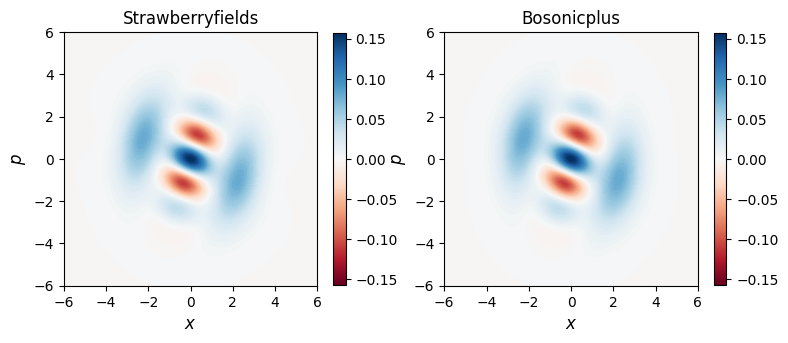

In [16]:
state = result.state

x = np.linspace(-6,6,100)
W = state.wigner(0, x,x)

fig, axes = plt.subplots(1,2, figsize = (9,4))
plot_wig(axes[0], W ,x,x)
axes[0].set_title(f'Strawberryfields')

#state_coherent = get_state(circuit)
W_coherent = state_coherent.get_wigner(x,x)
#W_coherent = get_wigner_coherent(state_coherent,x, x) 
plot_wig(axes[1], W_coherent, x, x)
axes[1].set_title(f'Bosonicplus')

plt.show()


## Post selecting on psuedo PNRD measurement outcome with bosonicplus
This method will run into precision issues the higher the number of on/off detectors per click detector `M` for the same reason that the bosonicbackend's Fock approximation runs into precision issues. 

In [17]:
num = 3
M = 8 #Number of on/off detectors per pPNRD
n = 5
ns = np.repeat(n, num-1) #Click outcomes

ti = time()
#params = gen_interferometer_params(num,12)
print('Building the interferometer')
print('-'*50)
state_th = build_interferometer(params, num, out=True)
#circuit = build_interferometer(params, num, out=True)
t1 = time()
print(f'Circuit building time = {t1-ti} s')

print('\nPerforming click measurements')
print('-'*50)

T0 = time()

for i, n in enumerate(ns):
    
    t0 = time()
    modes = np.arange(state_th.num_modes)
    #modes = circuit.get_modes()
    state_th.post_select_ppnrd_thermal(modes[-1], n, M, out=True)
    t1 = time()
    print(f'Post selection time {t1-t0} s')

T1 = time()

print(f'Total time for measurements {T1-T0} s')

print(f'\nTotal simulation time {T1-ti} s')
    

Building the interferometer
--------------------------------------------------
Sgate[0.265,-2.555] on mode 0
Sgate[0.370,-1.049] on mode 1
Sgate[0.343,1.415] on mode 2
BSgate[0.994,0.800] on modes 0 and 1
BSgate[0.792,3.093] on modes 1 and 2
BSgate[1.399,-2.663] on modes 0 and 1
Circuit building time = 0.0018422603607177734 s

Performing click measurements
--------------------------------------------------
Measuring 5 clicks in mode 2.
Data shape before measurement, [(1, 6), (1, 6, 6), (1,)].
Probability of measurement = 1.143e-05
Data shape after measurement, [(6, 4), (6, 4, 4), (6,)]
Post selection time 0.0006909370422363281 s
Measuring 5 clicks in mode 1.
Data shape before measurement, [(6, 4), (6, 4, 4), (6,)].
Probability of measurement = 1.075e-03
Data shape after measurement, [(36, 2), (36, 2, 2), (36,)]
Post selection time 0.0006341934204101562 s
Total time for measurements 0.0015630722045898438 s

Total simulation time 0.003631114959716797 s


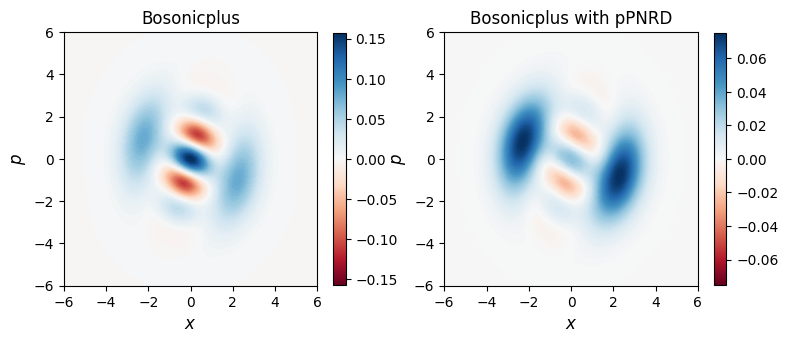

In [19]:

fig, axes = plt.subplots(1,2, figsize = (9,4))
plot_wig(axes[0], W_coherent, x, x)

axes[0].set_title(f'Bosonicplus')

#state_th = get_state(circuit)
W = state_th.get_wigner(x,x)

plot_wig(axes[1], W, x, x)
axes[1].set_title(f'Bosonicplus with pPNRD')

plt.show()